In [6]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

### First, deriving the scheme

First I want to rederive the scheme for SHE that will be used for fine and coarse grids.

We have:
$$
\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial t^2} = \xi (x,t)\\
\text{Integrating both sides over a square gives: }\\
\quad \int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{h}{2}}}^{j+{\frac{h}{2}}}\left(\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial t^2}\right) dxdy = \int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{h}{2}}}^{j+{\frac{h}{2}}}\xi(x,t) dx dy \\
\text{RHS - First term} \\
\int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{h}{2}}}^{j+{\frac{h}{2}}}\frac{\partial u}{\partial t} dx dy = \int_{x_{j-\frac{h}{2}}}^{j+{\frac{h}{2}}}(u(x, t_n) - u(x, t_{n+1})) dx \approx h \left( u_j^{n+1} - u_j^{n} \right)\\
\text{RHS - Second term} \\
\int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{h}{2}}}^{j+{\frac{h}{2}}}u_{xx}(t,x)dxdt = \int_{t_n}^{t_{n+1}} \left[u_x(t, x_j + \frac{h}{2}) - u_x(t, x_j - \frac{h}{2})\right] dt \approx \Delta t \left( \frac{u_{j+1}^{n} - 2 u_j^n + u_{j-1}^n}{h} \right) \\
\text{LHS} \\
\int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{h}{2}}}^{j+{\frac{h}{2}}} \xi(x,t) dx dy = \sqrt{\Delta x \Delta t} Z_i^n \quad \text{where } Z_i^n \sim \mathcal{N}(0, 1)\\
\text{Putting this together and rearranging yields: }\\
u_j^{n+1} = u_j^n + \frac{\Delta t}{(\Delta x)^2} \left(u_{j+1}^n - 2 u_j^n + u_{j-1}^n \right) + \sqrt{\frac{\Delta t}{\Delta x}} Z_i^n
$$
This is my finite difference scheme.
### Second, how do we couple noises together at different mesh levels?

So for this, it's crucial that noises from fine squares are used to construct the neighbouring squares. I'll do some work for this below in a notebook cell. The other thing is ensuring these scale to give the desired variance, which leads me to the next point...

### For the Stochastic Heat Equation

Bit of maths behind this one. First, we have that $\Delta x_c = 2 \Delta x_f$ and $\Delta t_c = 4 \Delta t_f$.

$$
\text{Target coarse variance: } \mathbb{V}\left[dWc \right] = \frac{\Delta t_c}{\Delta x_c}m=   \frac{4 \Delta t_f}{2 \Delta x_f} = 2 \frac{\Delta t}{\Delta f} \\
\text{Currently I'm summing 8 squares though...Let } \tilde{dW_c} \text{ be what I currently calculate by simply summing the neighbouring fine squares} \\
\mathbb{V} \left[\tilde{dW_c}\right] = \mathbb{V} \left[\sum_{i=1}^8 dW_f^{(i)} \right] = 8 \mathbb{V}\left[dW_f\right] = 8 \frac{\Delta t_f}{\Delta x_f} = 4 \mathbb{V}\left[dW_c\right]\\
\text{This is 4 times the variance I want. To resolve: } dW_c = \alpha \tilde{dW_c} \\
\mathbb{V}\left[ dW_c \right] = \alpha^2 \mathbb{V}\left[\tilde{dW_c}\right] \\
2 \frac{\Delta t_f}{\Delta x_f} = \alpha^2 8 \frac{\Delta t_f}{\Delta x_f} \\
\alpha^2 = \frac{1}{4} \quad \alpha = \frac{1}{2}
$$


In [21]:
## Let's explore noise resolution formulas then. First, the one suggested by Prof. Giles
u_fine = np.array([0, 1, 2, 3, 4, 5, 6, 7, 0])
nf = len(u_fine) - 1
nc = nf // 2
n_coarse = np.zeros(len(u_fine) // 2 + 1)
u_coarse[1:-1] = (
    0.5 * u_fine[1:-3:2] +
    u_fine[2:-2:2] +
    0.5 * u_fine[3:-1:2]
)
print(u_coarse) # all correct

[ 0.  4.  8. 12.  0.]


In [24]:
# And the previous method I was doing - what does that give me
u_fine[1:-2].reshape(nc - 1, 2).sum(axis=1)

array([ 3,  7, 11])

In [28]:
# And now for an array where rows are points and columns are samples
u_fine = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 0],
                   [0, 1, 2, 3, 4, 5, 6, 7, 0]]).T
u_coarse = np.zeros((nc + 1, 2))
u_coarse[1:-1, :] = (
    0.5 * u_fine[1:-3:2] + 
    u_fine[2:-2:2] + 
    0.5 * u_fine[3:-1:2]
)
u_coarse

array([[ 0.,  0.],
       [ 4.,  4.],
       [ 8.,  8.],
       [12., 12.],
       [ 0.,  0.]])

In [35]:
# and now if we just have the internal points
u_fine = np.array([[1, 2, 3, 4, 5, 6, 7],
                   [1, 2, 3, 4, 5, 6, 7]]).T
# u_coarse = np.zeros(((u_fine.shape[0] - 1) // 2, 2))
u_coarse = (0.5 * u_fine[:-2:2, :] + 
            u_fine[1:-1:2, :] + 
            0.5 * u_fine[2::2, :])
u_coarse


array([[ 4.,  4.],
       [ 8.,  8.],
       [12., 12.]])

In [ ]:
def default_noise_coupling(dWf):
    
    coupled_noises = (0.5 * dWf[:-2:2, :] +
                      dWf[1:-1:2, :] + 
                      0.5 * dWf[2::2, :])
    coupled_noises *= 0.5
    return coupled_noises
u_fine = np.array([[1, 2, 3, 4, 5, 6, 7],
                   [1, 2, 3, 4, 5, 6, 7]]).T
default_noise_coupling(u_fine) # all working

array([[2., 2.],
       [4., 4.],
       [6., 6.]])

In [40]:
def suspect_noise_coupling(dWf):
    num_rows = int(dWf.shape[0] / 2 - 0.5) # nf - 1 internal points for fine. Corresponds to (nf + 1) / 2 - 1 coarse internals
    dWc =  dWf[:-1, :].reshape(num_rows, 2, dWf.shape[1]).sum(axis=1) # sum of 2 fine adjacent increments, ignore final point
    return dWc

u_fine = np.array([[1, 2, 3, 4, 5, 6, 7],
                   [1, 2, 3, 4, 5, 6, 7]]).T
suspect_noise_coupling(u_fine)


array([[ 3,  3],
       [ 7,  7],
       [11, 11]])

l = 0
l = 1
l = 2
l = 3
l = 4
l = 5
l = 6
Estimates of key MLMC Theorem parameters based on linear regression: 
alpha = -0.244003 (exponent for MLMC weak convergence)
beta = 0.255117 (exponent for MLMC variance)
gamma = 2.879670 (exponent for MLMC cost
eps = 0.005
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 3 with remaining error 0.099972 > eps/sqrt(2) = 0.003536
New level 3 added, with 169 samples and variance 0.001206
Estimated alpha: 0.500000
Adding new level 4 with remaining error 0.046592 > eps/sqrt(2) = 0.003536
New level 4 added, with 82 samples and variance 0.000569
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 5 with remaining error 0.072329 > eps/sqrt(2) = 0.003536
New level 5 added, with 95 samples and variance 0.000719
Estimated alpha: 0.500000
Adding new level 6 with remaining error 0.052322 > eps/sqrt(2) = 0.003536
New level 6 added, with 45 samples and variance 0.000323
Es

KeyboardInterrupt: 

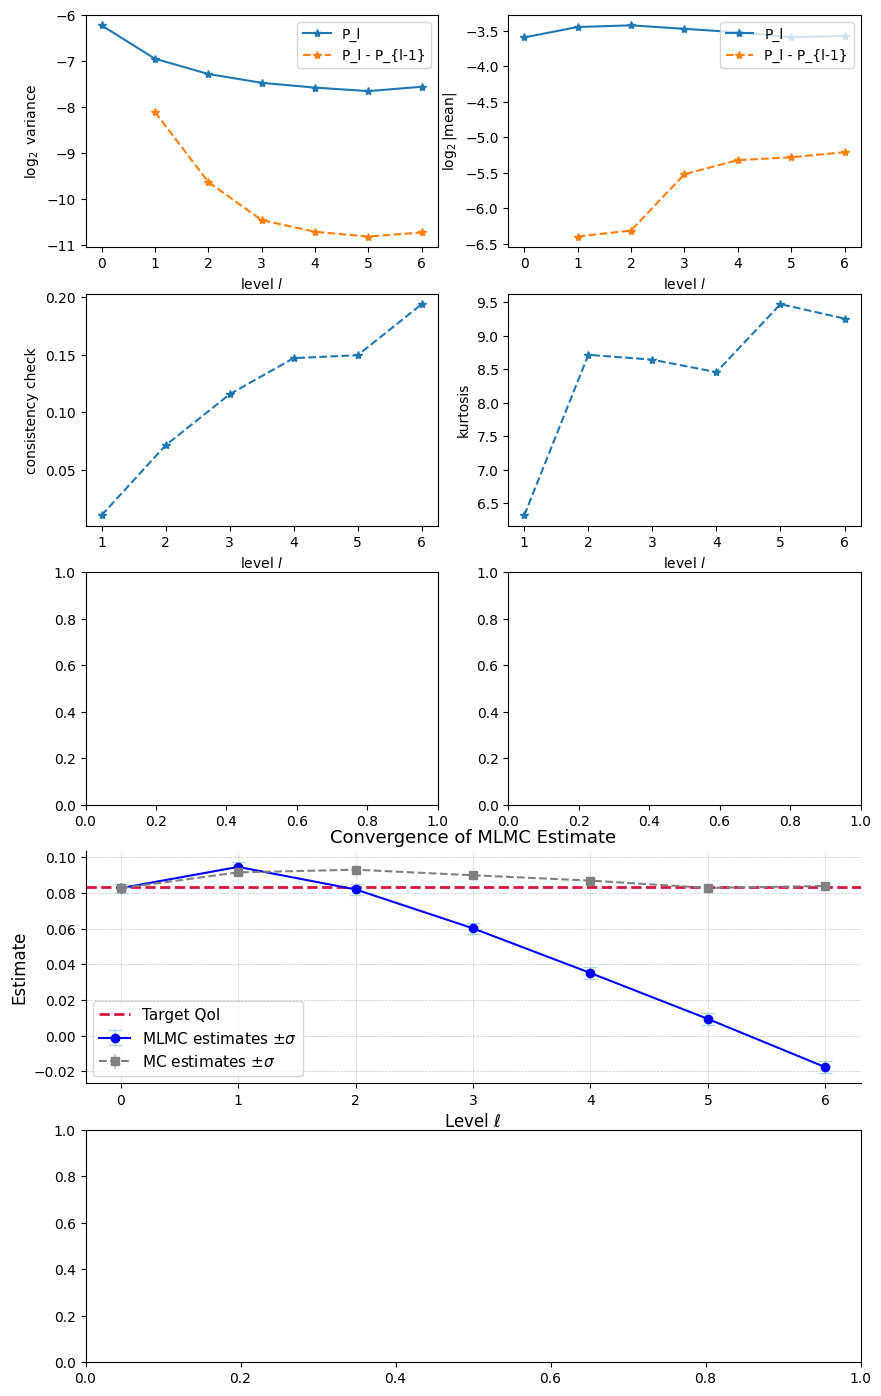

In [3]:
from mlmc.stoch_heat_eqn_qoi import stoch_heat_eqn_qoi
stoch_heat_eqn_qoi()

l = 0
l = 1
l = 2
l = 3
l = 4
l = 5
l = 6
Estimates of key MLMC Theorem parameters based on linear regression: 
alpha = 0.485730 (exponent for MLMC weak convergence)
beta = 2.143993 (exponent for MLMC variance)
gamma = 2.912247 (exponent for MLMC cost
eps = 0.005
Adding new level 3 with remaining error 0.106762 > eps/sqrt(2) = 0.003536
New level 3 added, with 74 samples and variance 0.000354
Adding new level 4 with remaining error 0.013257 > eps/sqrt(2) = 0.003536
New level 4 added, with 28 samples and variance 0.000127
Adding new level 5 with remaining error 0.008377 > eps/sqrt(2) = 0.003536
New level 5 added, with 6 samples and variance 0.000023
Adding new level 6 with remaining error 0.005161 > eps/sqrt(2) = 0.003536
New level 6 added, with 2 samples and variance 0.000005
Adding new level 7 with remaining error 0.005694 > eps/sqrt(2) = 0.003536
New level 7 added, with 1 samples and variance 0.000001
Adding new level 8 with remaining error 0.004067 > eps/sqrt(2) = 0.003536
New level 

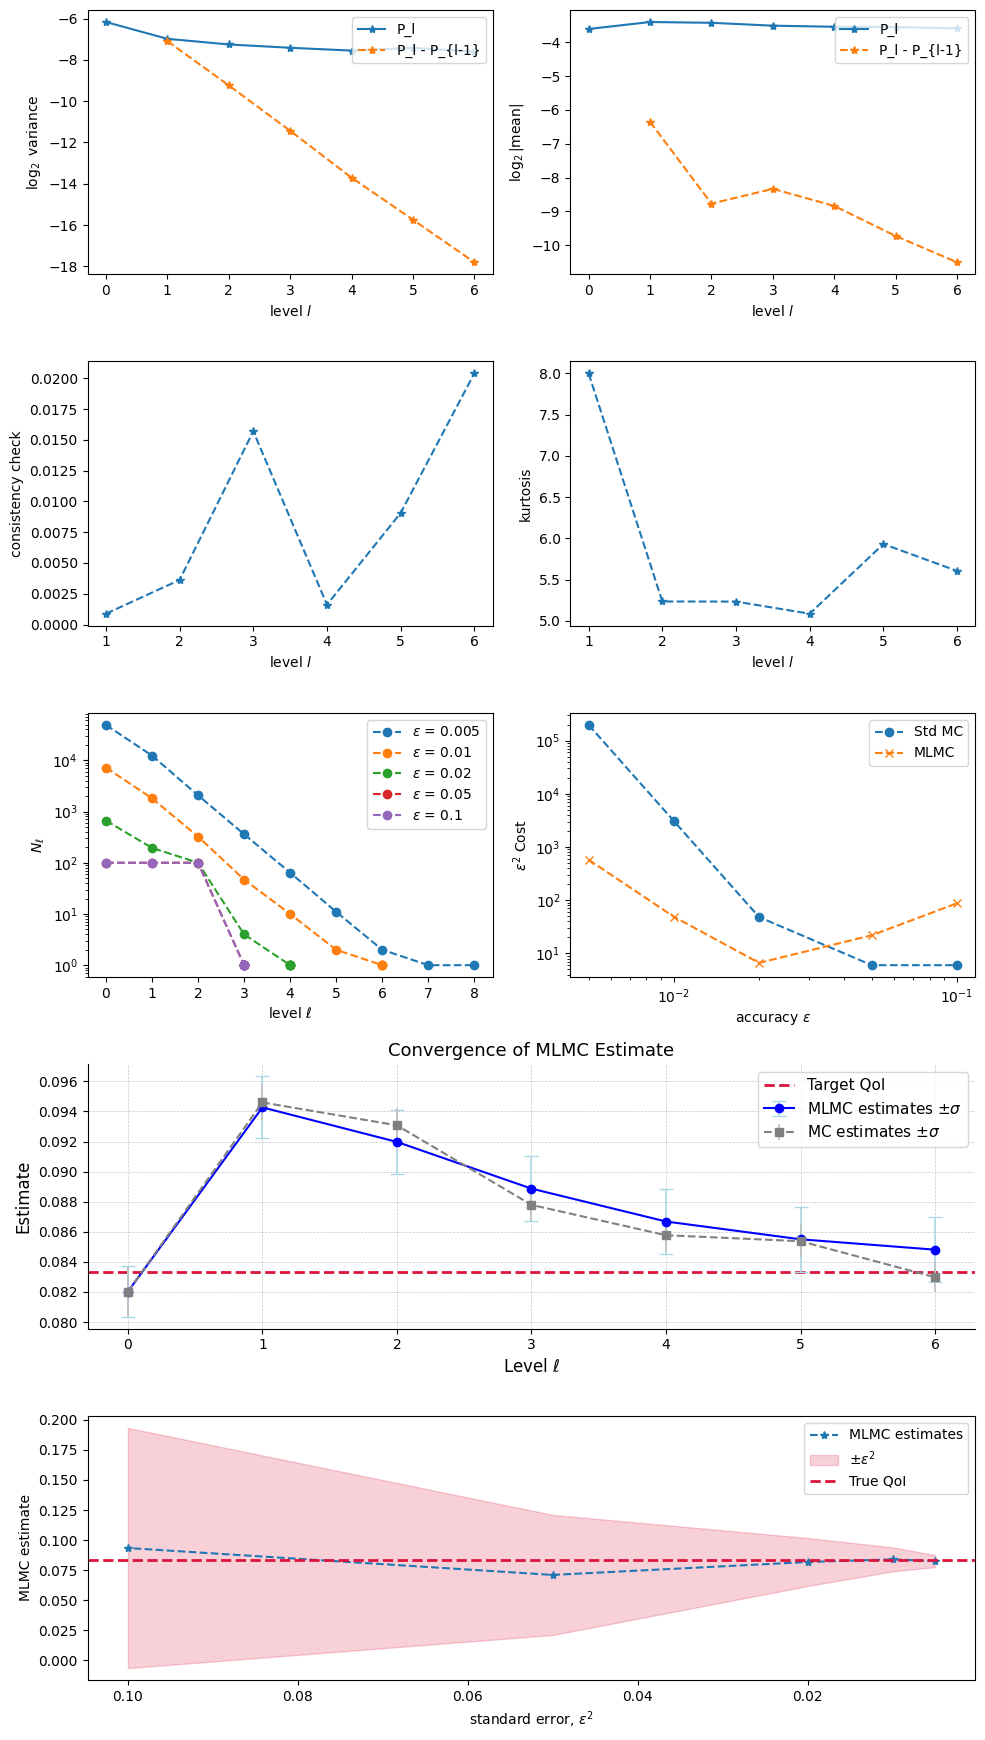

(array([ 0.08202383,  0.01224653, -0.00229493, -0.00310543, -0.00218695,
        -0.00118311, -0.00069059]),
 array([0.08202383, 0.09460226, 0.09307608, 0.08778917, 0.08576929,
        0.08537308, 0.08297702]),
 array([1.39034499e-02, 7.33091632e-03, 1.65902528e-03, 3.61267388e-04,
        7.49295918e-05, 1.82519707e-05, 4.37604243e-06]),
 array([0.01390345, 0.0079101 , 0.00654439, 0.00585573, 0.00532825,
        0.00583197, 0.00514404]))

In [8]:
from mlmc.stoch_heat_eqn_qoi import stoch_heat_eqn_qoi
def suspect_noise_coupling(dWf):
    num_rows = int(dWf.shape[0] / 2 - 0.5) # nf - 1 internal points for fine. Corresponds to (nf + 1) / 2 - 1 coarse internals
    dWc =  dWf[:-1, :].reshape(num_rows, 2, dWf.shape[1]).sum(axis=1) * 0.5 # sum of 2 fine adjacent increments, ignore final point
    return dWc

stoch_heat_eqn_qoi(noise_coupling=suspect_noise_coupling)

l = 0
l = 1
l = 2
l = 3
l = 4
l = 5
l = 6
Estimates of key MLMC Theorem parameters based on linear regression: 
alpha = -0.268114 (exponent for MLMC weak convergence)
beta = 0.210905 (exponent for MLMC variance)
gamma = 2.996771 (exponent for MLMC cost
eps = 0.005
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 3 with remaining error 0.100132 > eps/sqrt(2) = 0.003536
New level 3 added, with 204 samples and variance 0.001490
Estimated alpha: 0.500000
Adding new level 4 with remaining error 0.050596 > eps/sqrt(2) = 0.003536
New level 4 added, with 82 samples and variance 0.000579
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 5 with remaining error 0.060425 > eps/sqrt(2) = 0.003536
New level 5 added, with 66 samples and variance 0.000488
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 6 with remaining error 0.072268 > eps/sqrt(2) = 0.003536
New level 6 added, with 97 samples and variance 0.000770
Estimated alpha: 0.500000
Ad

KeyboardInterrupt: 

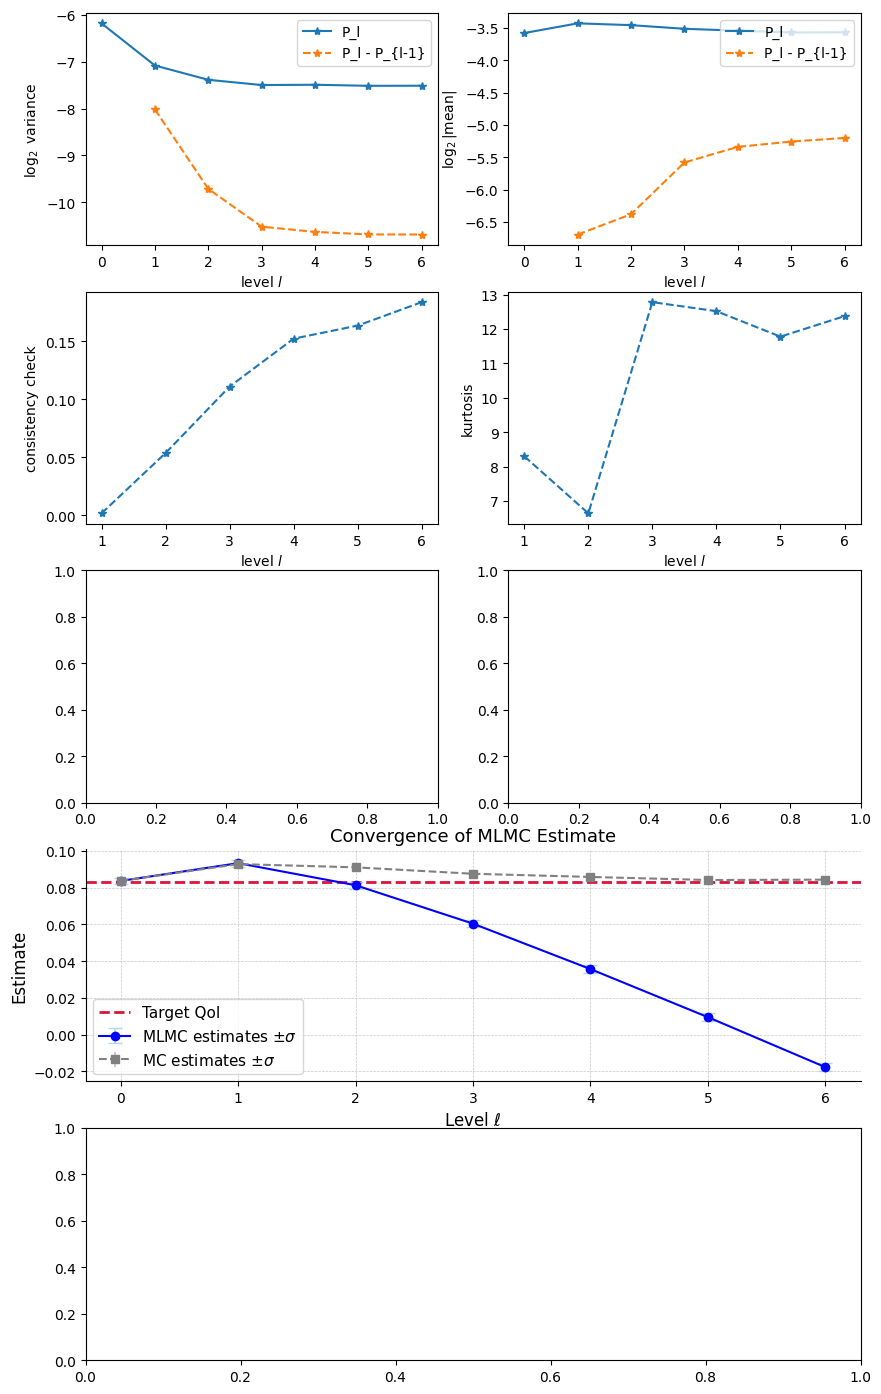

In [4]:
import numpy as np
from mlmc.stoch_heat_eqn_qoi import stoch_heat_eqn_qoi
def modified_noise_coupling(dWf):
    
    coupled_noises = (0.5 * dWf[:-2:2, :] +
                      dWf[1:-1:2, :] + 
                      0.5 * dWf[2::2, :])
    coupled_noises *= 1 / np.sqrt(3)
    return coupled_noises

stoch_heat_eqn_qoi(noise_coupling=modified_noise_coupling)

l = 0
l = 1
l = 2
l = 3
l = 4
l = 5
l = 6
Estimates of key MLMC Theorem parameters based on linear regression: 
alpha = 0.289367 (exponent for MLMC weak convergence)
beta = 0.029031 (exponent for MLMC variance)
gamma = 2.945331 (exponent for MLMC cost
eps = 0.005
Adding new level 3 with remaining error 0.251601 > eps/sqrt(2) = 0.003536
New level 3 added, with 141 samples and variance 0.001028
Adding new level 4 with remaining error 0.158737 > eps/sqrt(2) = 0.003536
New level 4 added, with 123 samples and variance 0.000938
Adding new level 5 with remaining error 0.104817 > eps/sqrt(2) = 0.003536
New level 5 added, with 115 samples and variance 0.000902
Adding new level 6 with remaining error 0.079521 > eps/sqrt(2) = 0.003536
New level 6 added, with 113 samples and variance 0.000897
Adding new level 7 with remaining error 0.064979 > eps/sqrt(2) = 0.003536
New level 7 added, with 138 samples and variance 0.001117
Adding new level 8 with remaining error 0.060665 > eps/sqrt(2) = 0.003536
Ne

KeyboardInterrupt: 

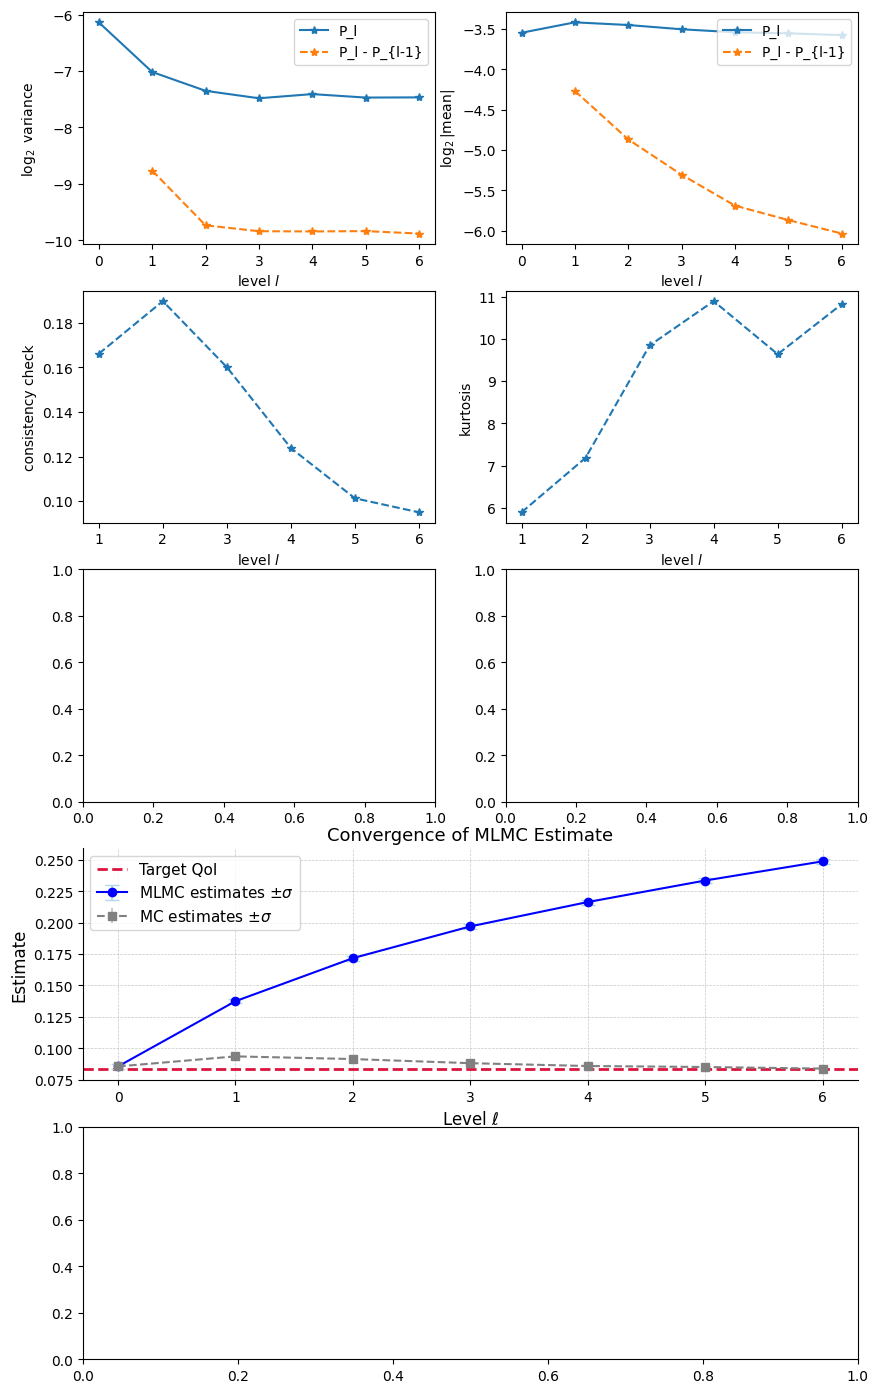

In [10]:
import numpy as np
def sum_of_3(dWf):    
    coupled_noises = (dWf[:-2:2, :] +
                      dWf[1:-1:2, :] + 
                      dWf[2::2, :])
    coupled_noises *= np.sqrt(1/12)
    return coupled_noises

stoch_heat_eqn_qoi(noise_coupling=sum_of_3)